<a href="https://colab.research.google.com/github/bartianbosch/Melk/blob/Oscar/Big_Data_Milk_Oscar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Big Data Groupwork Milk


In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
sp = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# Added our own necessary imports 
import seaborn as sns

from pyspark import SparkFiles

import pandas as pd
import matplotlib.pyplot as plt
plt.close('all')
plt.rcParams['figure.figsize'] = [30, 20]

from pyspark.sql import types
from pyspark.sql import functions as psf
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.regression import LinearRegression

# Mounting drive
from google.colab import drive
drive.mount('/content/gdrive/')

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:12 http://archive.ubuntu.com/ubu

Loading the data into a DF


In [43]:
## Loading the data

# Downloading the preprocessed datafile from the github in raw format
url = 'https://raw.githubusercontent.com/bartianbosch/Melk/main/ff_dairy_v1_preprocessed.csv'
url = 'https://raw.githubusercontent.com/bartianbosch/Melk/main/ff_dairy_v1_preprocessed_someNAfilledin.csv'
fileName = url.split('/')[-1] #The filename is everything after "main/"

# Prepare and load the file into a spark rdd
spark.sparkContext.addFile(url)
milk_rdd = spark.read.csv(SparkFiles.get(fileName), header=True)
milk_rdd = milk_rdd.repartitionByRange("Cow number")
print(type(milk_rdd))
print(milk_rdd.rdd.getNumPartitions())


# Also load the data to a pandas table, just in case we need it for testing.
milk_pd=pd.read_csv(url, encoding='latin1')


<class 'pyspark.sql.dataframe.DataFrame'>
101


In [44]:
# To check pandas dataframe, uncomment the following line:

#milk_pd

In [45]:
# To check spark rdd, uncomment the following line:
#milk_rdd.show(5)



---


## Creating a Machine Learning Model

### Data Preparation

In [46]:
## Fixing the RDD columns datatypes

# We need to change the datatype of each column in the rdd, to be able to
# process it correctly.

# TO-DO! FIND A WAY TO USE STRING COLUMNS IN ANALYSIS.

# Creating a function to set the given columns to the given datatype.
def fixType(datasetName, colName, dataType):
  """Takes a dataset and returns the dataset with the given column set to the given dataype"""
  return datasetName.withColumn(colName, psf.col(colName).cast(dataType))

# Preparing Lists with the column names according to which type they need to be.
allColumns = ['Cow number', 'Date', 'Barn', 'Barn part', 'Treatment', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)', 'Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Backfat Thickness', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Rumination time (min/day)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure dm (g/kg OM)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
doubleColumns = ['Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)']
intColumns = ['Cow number', 'Barn', 'Barn part', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Backfat Thickness', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Rumination time (min/day)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Manure dm (g/kg OM)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
stringColumn = ['Treatment', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)']
milk_rdd2 = milk_rdd

# Setting the columns to the correct type
for colName in doubleColumns:
  milk_rdd2 = fixType(milk_rdd2, colName, "double")
for colName in intColumns:
  milk_rdd2 = fixType(milk_rdd2, colName, "int")
milk_rdd2 = milk_rdd2.withColumn("Date", psf.col("Date").cast("date"))

# Uncomment the next line to check the schema
#milk_rdd2.printSchema()


In [47]:
## Create the vectorizer that adds the features column needed to run the machine learning pipeline

### To change on which columns the LR model is build you only need to change ###
### the 2 variables: inputColNames and labelColName ###

inputColNames = ['Water intake (kg)','Fat%', 'Protein%', 'Lactose%','Urea (mg/kg)', 'SCC (*1000/ml)']
inputColNames = ['Protein%','Cl (g/kg dm)','K (g/kg dm)','Fat%']
#inputColNames = ['Ca (g/day)', 'P (g/day)', 'Na (g/day)']
#inputColNames = doubleColumns[0:10]
#inputColNames = intColumn

labelColName = "Milk yield (kg)"
predictionColName = "Predicted " + labelColName

# Removing the label column from the input column if it ended in there on accident
if labelColName in inputColNames: inputColNames.remove(labelColName)

# Drop empty values (otherwise it can't work with the data)
# WE MIGHT NEED TO FIND AN ALTERNATIVE TO DROPPING ANY ROW WITH BLANKS!
milk_rdd3 = milk_rdd2.select(inputColNames+[labelColName]).dropna(how='any')
milk_rdd3.show(5)

+--------+------------+-----------+----+---------------+
|Protein%|Cl (g/kg dm)|K (g/kg dm)|Fat%|Milk yield (kg)|
+--------+------------+-----------+----+---------------+
|    3.21|           5|         15|3.24|          36.44|
|    3.21|           5|         15|3.24|          35.59|
|    3.21|           5|         15|3.24|          37.86|
|    3.21|           5|         15|3.24|          36.27|
|    3.21|           5|         15|3.24|          36.78|
+--------+------------+-----------+----+---------------+
only showing top 5 rows



In [48]:
### EXPERIMENTING WITH FILLING IN NA ###

df = milk_rdd2.select(inputColNames+[labelColName])

In [49]:
## Assembling the vectorizer
vectorizer = VectorAssembler(
    inputCols=inputColNames, 
    outputCol="features")

In [50]:
## Splitting the dataset into a training and testing portion.

# Setting a seed for reproducible results.
ourSeed = 1234  # default = 1234

# Randomly splitting the dataset (default 20% test, 80% train)
(testSetDF, trainingSetDF) = milk_rdd3.randomSplit([2.0,8.0],seed=ourSeed)

# Uncomment to cache these datasets for performance
testSetDF.cache()
trainingSetDF.cache()

DataFrame[Protein%: double, Cl (g/kg dm): int, K (g/kg dm): int, Fat%: double, Milk yield (kg): double]

### Linear Regression Machine Learning Model

In [51]:
## Training a linear regression model with the default settings.

# Initialize the linear regression learner with default values for the parameters
lr = LinearRegression()

# Setting the name of the column with the values that need to be learned
# and setting the name of the column where the predicted results will be saved.
lr.setLabelCol(labelColName)\
  .setPredictionCol(predictionColName)

# Create a pipeline that performs the vectorizer and the Linear Regression
# learning model.
lrPipeline = Pipeline()
lrPipeline.setStages([vectorizer, lr])

# Uncomment the next line to show if the training set was created correctly
#trainingSetDF.show(5)

# Train the model on the training set with the default settings.
trainingSetDF.show(5)
lrModel = lrPipeline.fit(trainingSetDF)


+--------+------------+-----------+----+---------------+
|Protein%|Cl (g/kg dm)|K (g/kg dm)|Fat%|Milk yield (kg)|
+--------+------------+-----------+----+---------------+
|    3.13|           5|         15|3.52|          25.36|
|    3.13|           5|         15|3.52|          26.38|
|    3.13|           5|         15|3.52|          27.09|
|    3.13|           5|         15|3.52|          27.47|
|    3.13|           5|         15|3.52|           28.6|
+--------+------------+-----------+----+---------------+
only showing top 5 rows



In [52]:
## Inspecting the results of the previous model

# The coefficients (i.e., weights) are as follows:
weights = lrModel.stages[1].coefficients

# The corresponding features for these weights are:
featuresNoLabel = vectorizer.getInputCols()

# Print coefficients 
list(zip(featuresNoLabel, weights))
print(list(zip(featuresNoLabel, weights)))
 
 # Print the intercept
print("Intercept: ",lrModel.stages[1].intercept)

[('Protein%', -6.339845862223713), ('Cl (g/kg dm)', -6.090083774167062), ('K (g/kg dm)', 0.1216366841008157), ('Fat%', -2.8693162003533534)]
Intercept:  90.20255372417603


+--------+------------+-----------+----+---------------+-------------------------+
|Protein%|Cl (g/kg dm)|K (g/kg dm)|Fat%|Milk yield (kg)|Predicted Milk yield (kg)|
+--------+------------+-----------+----+---------------+-------------------------+
|    3.13|           5|         15|3.52|          31.57|       31.632974540848927|
|    3.17|           5|         15|3.36|          36.89|       31.838471298416508|
|    3.21|           5|         15|3.24|          34.52|        31.92919540796997|
|    3.21|           5|         15|3.24|          35.59|        31.92919540796997|
|    3.21|           5|         15|3.24|          36.78|        31.92919540796997|
|    3.21|           5|         15|3.24|          37.86|        31.92919540796997|
|    3.22|           5|         15|3.37|          31.71|       31.492785843301796|
|    3.22|           5|         15|3.37|          35.05|       31.492785843301796|
|    3.23|           5|         15| 3.0|          33.94|       32.491034378810305|
|   

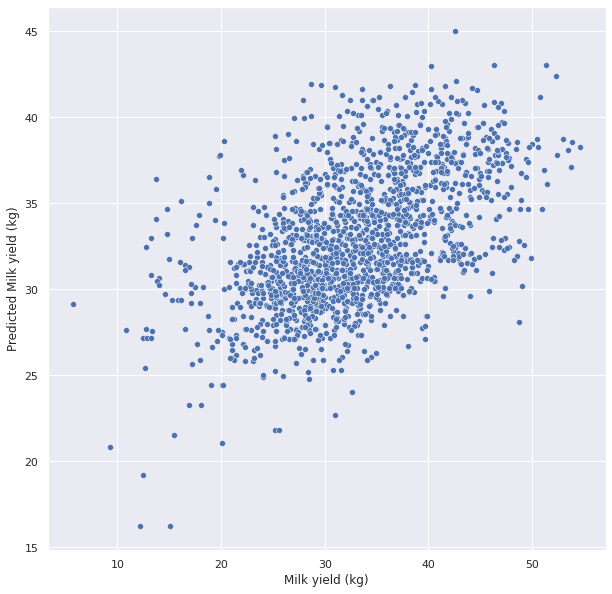

In [53]:
## Model Predictions:

 # Apply our LR model to the test data and predict power output
predictionsLR = lrModel.transform(testSetDF).select(inputColNames+[labelColName]+[predictionColName])

 # Print the first 15 rows of your predictions
predictionsLR.show(15)

#Plotting predicted against actual values to show linearity
sns.scatterplot(x=labelColName, y=predictionColName, data=predictionsLR.toPandas())

In [54]:
## Compute an evaluation metric for our test dataset

# Create an RMSE evaluator using the label and predicted columns
regEval = RegressionEvaluator(predictionCol=predictionColName, labelCol=labelColName, metricName="rmse")

# Run the evaluator on the DataFrame
rmse = regEval.evaluate(predictionsLR)

# Print the Root Mean Squared Error
print("Root Mean Squared Error: %.2f" % rmse)

Root Mean Squared Error: 6.24


In [55]:
## Compute R-squared evaluation metric for our test dataset

r2 = regEval.evaluate(predictionsLR, {regEval.metricName: "r2"})

# Print R-squard
print("r2: {0:.2f}".format(r2))

r2: 0.29


### Parameter Tuning and Evaluation

In [56]:
## Use paramater tuning to try to create a better linear regression model

# We can reuse the RegressionEvaluator, regEval, to judge the model based on the best Root Mean Squared Error
# Let's create our CrossValidator with 3 fold cross validation
crossval = CrossValidator(estimator=lrPipeline, evaluator=regEval, numFolds=3)

# Tune over our regularization parameter from 0.01 to 0.10
regParam = [x / 100.0 for x in range(1, 11)]

# Create a paramter grid using the ParamGridBuilder,
# and add the grid to the CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, regParam)
             .build())
crossval.setEstimatorParamMaps(paramGrid)

# Find and return the best model
cvModel = crossval.fit(trainingSetDF).bestModel

In [57]:
## Evaluate the new tuned model by comparing it to the default linear regression

# Use cvModel to compute an evaluation metric for our test dataset: testSetDF
predictionsRL = cvModel.transform(testSetDF).select(inputColNames+[labelColName]+[predictionColName])

# Run the previously created RMSE evaluator, regEval, on the predictionsAndLabelsDF DataFrame
rmseLR = regEval.evaluate(predictionsRL)

# Compute the r2 evaluation metric for our test dataset
r2LR = regEval.evaluate(predictionsRL, {regEval.metricName: "r2"})

# Printing the rounded values to compare the 2 linear regression models.
print("Original Root Mean Squared Error: {0:2.2f}".format(rmse))
print("New Root Mean Squared Error: {0:2.2f}".format(rmseLR))
print("Old r2: {0:2.2f}".format(r2))
print("New r2: {0:2.2f}".format(r2LR))

# Printing unrounded values for better testing purpose
print("\r\n","Un-rouned values printed above in same order:\r\n",rmse,rmseLR,r2,r2LR)

Original Root Mean Squared Error: 6.24
New Root Mean Squared Error: 6.24
Old r2: 0.29
New r2: 0.29

 Un-rouned values printed above in same order:
 6.2366362741439385 6.236722747475733 0.2922368244686 0.2922171975217912


# Visualization

## Plotting sample of dataset against 1 column

In [58]:
## Copy of setting the correct columns to allow easier plotting

### CHANGE inputColNames (list of x) AND LabelColName (y) TO CREATE THE
### DESIRED PLOTS. # ONLY 10 x VALUES CAN BE ENTERED AT A TIME

inputColNames = ['Water intake (kg)','Fat%', 'Protein%', 'Lactose%','Urea (mg/kg)', 'SCC (*1000/ml)']
#inputColNames = doubleColumns[0:10]

labelColName = "Milk yield (kg)"
predictionColName = "Predicted " + labelColName

# Removing the label column from the input column if it ended in there on accident
if labelColName in inputColNames: inputColNames.remove(labelColName)

# Drop empty values (otherwise it can't work with the data)
# WE MIGHT NEED TO FIND AN ALTERNATIVE TO DROPPING ANY ROW WITH BLANKS!
# CURRENTLY EXPERIMENTING WITH NOT DROPPING NA FOR THE PLOTTING
#milk_rdd3 = milk_rdd2.dropna(how='any', subset=inputColNames+[labelColName])
milk_rdd3 = milk_rdd2.select(inputColNames+[labelColName])

<Figure size 720x720 with 0 Axes>

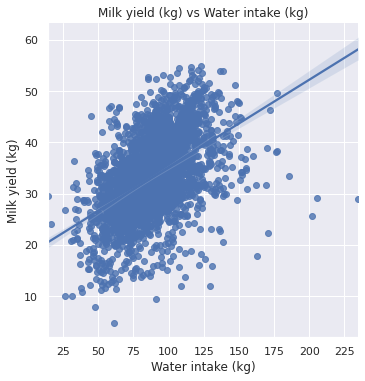

<Figure size 720x720 with 0 Axes>

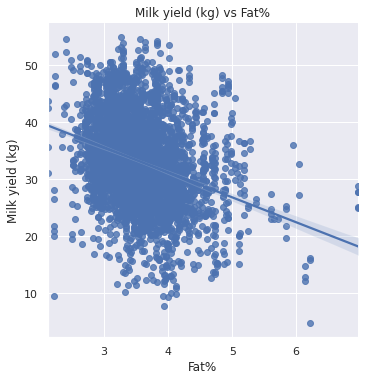

<Figure size 720x720 with 0 Axes>

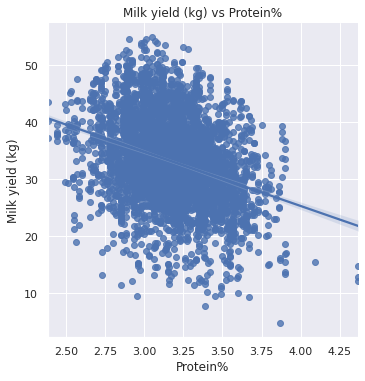

<Figure size 720x720 with 0 Axes>

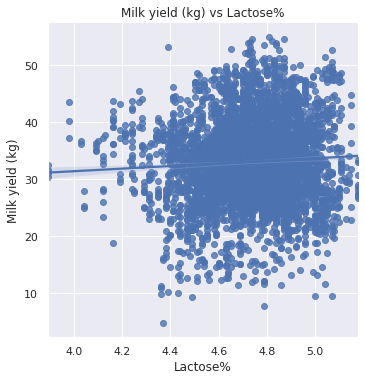

<Figure size 720x720 with 0 Axes>

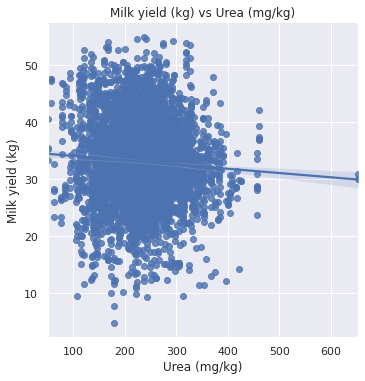

<Figure size 720x720 with 0 Axes>

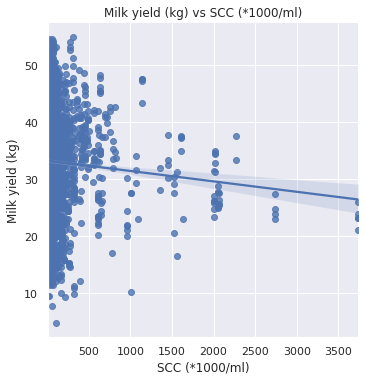

In [59]:
## Plotting the columns versus the labelcolumn to get inital idea of linear regression

### Trying to plot more than 10 plots at the same time results in empty plots ###

milk_rdd3_sample = milk_rdd3.select(inputColNames+[labelColName]).sample(False,0.5)
#print(milk_rdd3_sample)
sns.set(rc={'figure.figsize':(10,10)})

for column in inputColNames:
  plt.figure()
  sns.lmplot(x=column, y=labelColName,data=milk_rdd3_sample.toPandas())
  plt.title(labelColName+" vs "+column)
  plt.xlabel(column)
  plt.ylabel(labelColName)

In [60]:
inset = doubleColumns+intColumns
inset.remove("Milk yield (kg)")
print(inset)
bigshitresult = {}
for bigshit in inset:


  ## Create the vectorizer that adds the features column needed to run the machine learning pipeline

  ### To change on which columns the LR model is build you only need to change ###
  ### the 2 variables: inputColNames and labelColName ###

  inputColNames = [bigshit]
  #inputColNames = ['Water intake (kg)','Fat%', 'Protein%', 'Lactose%','Urea (mg/kg)', 'SCC (*1000/ml)']
  #inputColNames = ['Water intake (kg)','Fat%', 'Protein%', 'Lactose%']
  #inputColNames = ['Ca (g/day)', 'P (g/day)', 'Na (g/day)']
  #inputColNames = doubleColumns[0:10]
  #inputColNames = intColumn

  labelColName = "Milk yield (kg)"
  predictionColName = "Predicted " + labelColName

  # Removing the label column from the input column if it ended in there on accident
  if labelColName in inputColNames: inputColNames.remove(labelColName)

  # Drop empty values (otherwise it can't work with the data)
  # WE MIGHT NEED TO FIND AN ALTERNATIVE TO DROPPING ANY ROW WITH BLANKS!
  milk_rdd3 = milk_rdd2.dropna(how='any', subset=inputColNames+[labelColName])

  ## Assembling the vectorizer
  vectorizer = VectorAssembler(
      inputCols=inputColNames, 
      outputCol="features")

  ## Splitting the dataset into a training and testing portion.

  # Setting a seed for reproducible results.
  ourSeed = 1234  # default = 1234

  # Randomly splitting the dataset (default 20% test, 80% train)
  (testSetDF, trainingSetDF) = milk_rdd3.randomSplit([2.0,8.0],seed=ourSeed)

  # Uncomment to cache these datasets for performance
  testSetDF.cache()
  trainingSetDF.cache()

  ## Training a linear regression model with the default settings.

  # Initialize the linear regression learner with default values for the parameters
  lr = LinearRegression()

  # Setting the name of the column with the values that need to be learned
  # and setting the name of the column where the predicted results will be saved.
  lr.setLabelCol(labelColName)\
    .setPredictionCol(predictionColName)

  # Create a pipeline that performs the vectorizer and the Linear Regression
  # learning model.
  lrPipeline = Pipeline()
  lrPipeline.setStages([vectorizer, lr])

  # Uncomment the next line to show if the training set was created correctly
  #trainingSetDF.show(5)

  # Train the model on the training set with the default settings.
  #trainingSetDF.show(5)
  lrModel = lrPipeline.fit(trainingSetDF)

  ## Inspecting the results of the previous model

  # The coefficients (i.e., weights) are as follows:
  weights = lrModel.stages[1].coefficients

  # The corresponding features for these weights are:
  featuresNoLabel = vectorizer.getInputCols()

  # Print coefficients 
  list(zip(featuresNoLabel, weights))
  print(list(zip(featuresNoLabel, weights)))
  
  # Print the intercept
  print("Intercept: ",lrModel.stages[1].intercept)
  #bigshitresult[bigshit]=list(zip(featuresNoLabel, weights))
  bigshitresult[bigshit]=weights.values
print(bigshitresult)

with open("/result.txt", "w") as l:
  print(bigshitresult, file=l)

['Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Fat%', 'Protein%', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'Cow number', 'Barn', 'Barn part', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Backfat Thickness', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Rumination time (min/day)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Manure dm (g/kg OM)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (

In [61]:
l = []
for k,v in bigshitresult.items():
  l.append(v)

import operator
x = bigshitresult
sorted_x = sorted(x.items(), key=operator.itemgetter(1))

print(sorted_x)

[('Number of kernels', array([-10.36357143])), ('Protein%', array([-9.41651997])), ('Protein% preperiod', array([-8.05022344])), ('BCS', array([-6.07045008])), ('Cl (g/kg dm)', array([-6.06270498])), ('K (g/kg dm)', array([-4.77290925])), ('Fat%', array([-4.22223778])), ('Fat% preperiod', array([-2.96103022])), ('Manure fibre score (1=short, 5 = long)', array([-2.7214375])), ('SPE (g/kg dm)', array([-2.34540893])), ('Manure consistency (1=fluid, 5= hard)', array([-1.34444444])), ('plusI (/kg dm)', array([-0.85152343])), ('Backfat Thickness', array([-0.77485495])), ('Week', array([-0.75416975])), ('TPK (g/kg dm)', array([-0.68323808])), ('WI (/kg dm)', array([-0.38657667])), ('Crude fiber (g/kg dm)', array([-0.34356796])), ('Manure dm (g/kg OM)', array([-0.20851066])), ('SPK (g/kg dm)', array([-0.16547665])), ('Day number', array([-0.10776645])), ('Time pH<5,8 (h)', array([-0.10057218])), ('Days in milk', array([-0.06369718])), ('Avg Temperature (degC)', array([-0.05056705])), ('Urea (m

## Splitting the dataset

In [80]:
## Loading the data

# Downloading the preprocessed datafile from the github in raw format
url = 'https://raw.githubusercontent.com/bartianbosch/Melk/main/ff_dairy_v1_preprocessed.csv'
url = 'https://raw.githubusercontent.com/bartianbosch/Melk/main/ff_dairy_v1_preprocessed_someNAfilledin.csv'
fileName = url.split('/')[-1] #The filename is everything after "main/"

# Prepare and load the file into a spark rdd
spark.sparkContext.addFile(url)
milk_rdd = spark.read.csv(SparkFiles.get(fileName), header=True)
milk_rdd = milk_rdd.repartitionByRange("Cow number")
print(type(milk_rdd))
print(milk_rdd.rdd.getNumPartitions())

## Fixing the RDD columns datatypes

# We need to change the datatype of each column in the rdd, to be able to
# process it correctly.

# TO-DO! FIND A WAY TO USE STRING COLUMNS IN ANALYSIS.

# Creating a function to set the given columns to the given datatype.
def fixType(datasetName, colName, dataType):
  """Takes a dataset and returns the dataset with the given column set to the given dataype"""
  return datasetName.withColumn(colName, psf.col(colName).cast(dataType))

# Preparing Lists with the column names according to which type they need to be.
allColumns = ['Cow number', 'Date', 'Barn', 'Barn part', 'Treatment', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)', 'Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Backfat Thickness', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Rumination time (min/day)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure dm (g/kg OM)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
doubleColumns = ['Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)']
intColumns = ['Cow number', 'Barn', 'Barn part', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Backfat Thickness', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Rumination time (min/day)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Manure dm (g/kg OM)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
stringColumn = ['Treatment', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)']
milk_rdd2 = milk_rdd

# Setting the columns to the correct type
for colName in doubleColumns:
  milk_rdd2 = fixType(milk_rdd2, colName, "double")
for colName in intColumns:
  milk_rdd2 = fixType(milk_rdd2, colName, "int")
milk_rdd2 = milk_rdd2.withColumn("Date", psf.col("Date").cast("date"))

# Uncomment the next line to check the schema
#milk_rdd2.printSchema()

def show_partition_id(df):
    """Helper function to show partition."""
    return df.select(*df.columns, psf.spark_partition_id().alias("pid")).show()
#print(show_partition_id(milk_rdd2))

#milk_rdd2.select(*milk_rdd2.columns, psf.spark_partition_id().alias("pid")).sample(False, 0.01, seed=0).limit(20).show()




<class 'pyspark.sql.dataframe.DataFrame'>
101
+----------+----+----+---------+---------+----------------+------------+----------+----+------------------------------------------+-----------------------------------------------+---------------------------+---------------------------+-----------------+-----------------------+-----------+----+-----------------+---------------+----+--------+------------+--------------+--------+----------------------+---------+----------------------+-------------------------+------+----------------------+---------------+-------------------------------------+--------------------------------------+-----------------+-------------------------+-------------------+-----------------------+-------+-------------------------+--------------------------+--------------+------------------+------------------+----------------------+------------------+--------+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+-------